# Some quick postprocessing of MOM6 data to generate SST, MOC, and OHT figures

## Dependencies:
- xarray
- numpy
- cartopy
- matplotlib

In [10]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings

#=================================================
# Modify paths to point to output files
#=================================================
# Case name
case = 'Straight Coast'

# path to ocean_annual file
path_year = '/data2/sragen/MOM6_cases/aquaplanet/MASTERS/straight_coast/run/DATA/780yr_no_salt_restore/26500101.ocean_annual.nc'
dy = xr.open_dataset(path_year)

# path to ocean_month file
path_month = '/data2/sragen/MOM6_cases/aquaplanet/MASTERS/straight_coast/run/DATA/780yr_no_salt_restore/26500101.ocean_month.nc'
dm = xr.open_dataset(path_month)

# define some useful variables
lat = dy['yq']
lon = dy['xh']
z = dy['zl']
vmo = dy['vmo']
vhGM = dy['vhGM']
T_ady_2d = dm['T_ady_2d'][-361:-1]
T_diffy_2d = dm['T_diffy_2d'][-361:-1]

#=================================================
# Ignore runtime warnings: mean of empty slice
#=================================================
warnings.filterwarnings("ignore", message="Mean of empty slice")

#=================================================
# Modify latitudes to point to western and eastern
# boundaries of small basin and northern extent of SO.
# Comment out for AQUA and RIDGE cases. 
#=================================================
x_west = np.where(dy['xh']==211)[0][0]
x_east = np.where(dy['xh']==351)[0][0]
y = np.where(dy['yq']==-35)[0][0]
y_south = np.where(dy['yq']==-71)[0][0]
y_north = np.where(dy['yq']==71)[0][0]

/usr/local/anaconda3/lib/python3.7/site-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)


# Functions used in this notebook

In [3]:
def calculate_OHT(T_ady_2d, T_diffy_2d):
    tady = np.where(np.abs(T_ady_2d) == 1e+20, np.nan, T_ady_2d)
    tady_avg = np.nanmean(tady, axis=0)
    tady_zonal = np.nansum(tady_avg, axis=1)
    tdiffy = np.where(np.abs(T_diffy_2d) == 1e+20, np.nan, T_diffy_2d)
    tdiffy_avg = np.nanmean(tdiffy, axis=0)
    tdiffy_zonal = np.nansum(tdiffy_avg, axis=1)
    OHT = (tady_zonal + tdiffy_zonal)/1e15
    return OHT

def calculate_global_sfn(vmo, vhGM):
    vmo_slice = (np.nanmean(vmo[-31:-1,:,:,:], axis=0))
    vhGM_slice = (np.nanmean(vhGM[-31:-1,:,:,:], axis=0))
    sfn_global_mean = (np.cumsum(np.nansum(vmo_slice/1025, axis=2), axis=0))/(1e6)
    sfn_global_res = (np.cumsum(np.nansum(vhGM_slice/1025, axis=2), axis=0))/(1e6)
    sfn_global_resmean = sfn_global_mean + sfn_global_res
    return sfn_global_mean, sfn_global_res, sfn_global_resmean

def calculate_basin_sfn(vmo, vhGM, x_west, x_east, y_south, y_north):
    vmo_slice = (np.nanmean(vmo[-31:-1,:,:,:], axis=0))
    vhGM_slice = (np.nanmean(vhGM[-31:-1,:,:,:], axis=0))
    sfn_basin_mean = (np.cumsum(np.nansum((vmo_slice[:,y_south:y_north,x_west:x_east])/1025, axis=2), axis=0))/(1e6)
    sfn_basin_res = (np.cumsum(np.nansum((vhGM_slice[:,y_south:y_north,x_west:x_east])/1025, axis=2), axis=0))/(1e6)
    sfn_basin_resmean = sfn_basin_mean + sfn_basin_res
    return sfn_basin_mean, sfn_basin_res, sfn_basin_resmean

def variablename(*arg):
    names = []
    for i in range(len(arg)):
        item = [tpl[0] for tpl in filter(lambda x: arg[i] is x[1], globals().items())]
        names.append(item)
    str(names).strip('[]')
    return names

def plot_global_sfn(sfn_mean, sfn_res, sfn_resmean, sfn_bound, y_south, y_north):
    t = np.linspace(-sfn_bound, sfn_bound, 11, endpoint=True)
    b = np.linspace(-sfn_bound, sfn_bound, 21, endpoint=True)
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,12))
    sfn_list = sfn_mean, sfn_res, sfn_resmean
    names = variablename(sfn_mean, sfn_res, sfn_resmean)
    for row in range(3):
        ax = axs[row]
        cf = ax.contourf(lat, z, sfn_list[row], b, cmap='coolwarm', extend='both')
        ax.invert_yaxis()
        ax.set_xlim(-np.abs(y_south), y_north)
        plt.ylabel('Depth', fontsize=14), plt.xlabel('Latitude', fontsize=14)
        ax.set_title('{}'.format(str(names[row]).strip("['']"))+' '+'{}'.format(case), fontsize=16)
        cbar = fig.colorbar(cf, ax=ax, ticks=t, format = '%.0f')
        cbar.ax.set_ylabel('[Sv]', fontsize=12)
    plt.show()
    return

def plot_basin_sfn(sfn_mean, sfn_res, sfn_resmean, sfn_bound, y_south, y_north):
    t = np.linspace(-sfn_bound, sfn_bound, 11, endpoint=True)
    b = np.linspace(-sfn_bound, sfn_bound, 21, endpoint=True)
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,12))
    sfn_list = sfn_mean, sfn_res, sfn_resmean
    names = variablename(sfn_mean, sfn_res, sfn_resmean)
    for row in range(3):
        ax = axs[row]
        cf = ax.contourf(lat[y_south:y_north], z, sfn_list[row][:,:], b, cmap='coolwarm', extend='both')
        ax.invert_yaxis()
        ax.set_xlim(lat[y_south], lat[y_north-1])
        ax.set_title('{}'.format(str(names[row]).strip("['']"))+' '+'{}'.format(case), fontsize=16)
        cbar = fig.colorbar(cf, ax=ax, ticks=t, format = '%.0f')
        cbar.ax.set_ylabel('[Sv]', fontsize=12)
    axs[1].set_ylabel('Depth', fontsize=14), axs[2].set_xlabel('Latitude', fontsize=14)
    plt.show()
    return

def plot_salt_section(title, lon_index, z):
    t = np.linspace(33, 38, 11, endpoint=True)
    b = np.linspace(33, 38, 21, endpoint=True)
    lon = np.asarray(dy['xh'][lon_index])
    fig, ax = plt.subplots(figsize=(9,5))
    cf = ax.contourf(dy['yh'], dy['zl'][0:z], np.squeeze(salt[:z,:,lon_index]), b, extend='both')
    ax.invert_yaxis()
    ax.set_xlim(-70, 70)
    plt.ylabel('Depth', fontsize=14), plt.xlabel('Latitude', fontsize=14)
    ax.set_title(title+' '+'Salinity Section at'+' '+'{}'.format(lon)+'E', fontsize=16)
    cbar = fig.colorbar(cf, ax=ax, ticks=t, format = '%.0f')
    cbar.ax.set_ylabel('[psu]', fontsize=12)
    plt.show()
    return

def plot_temp_section(title, lon_index, z):
    t = np.linspace(-5, 30, 11, endpoint=True)
    b = np.linspace(-5, 30, 21, endpoint=True)
    lon = np.asarray(dy['xh'][lon_index])
    fig, ax = plt.subplots(figsize=(9,5))
    cf = ax.contourf(dy['yh'], dy['zl'][0:z], np.squeeze(temp[:z,:,lon_index]), b, cmap='coolwarm', extend='both')
    ax.invert_yaxis()
    ax.set_xlim(-70, 70)
    plt.ylabel('Depth', fontsize=14), plt.xlabel('Latitude', fontsize=14)
    ax.set_title(title+' '+'Temperature Section at'+' '+'{}'.format(lon)+'E', fontsize=16)
    cbar = fig.colorbar(cf, ax=ax, ticks=t, format = '%.0f')
    cbar.ax.set_ylabel('[C]', fontsize=12)
    plt.show()
    return

# Look at global mean SST and SSS

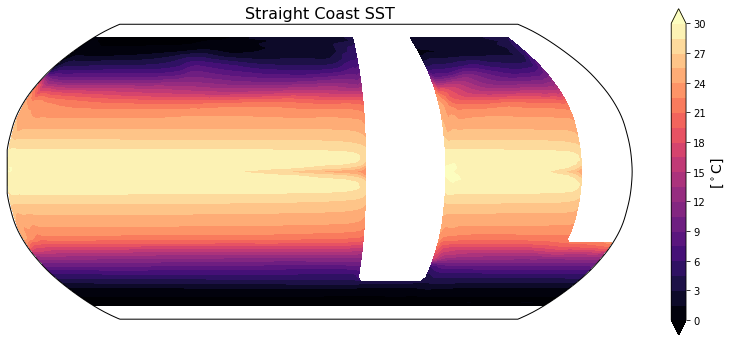

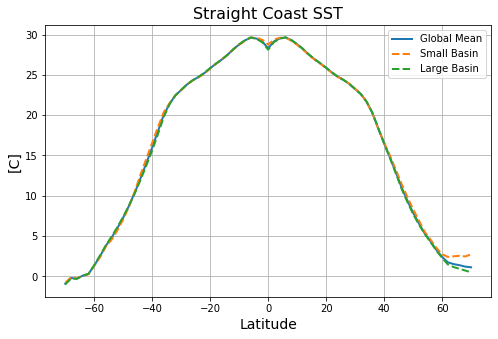

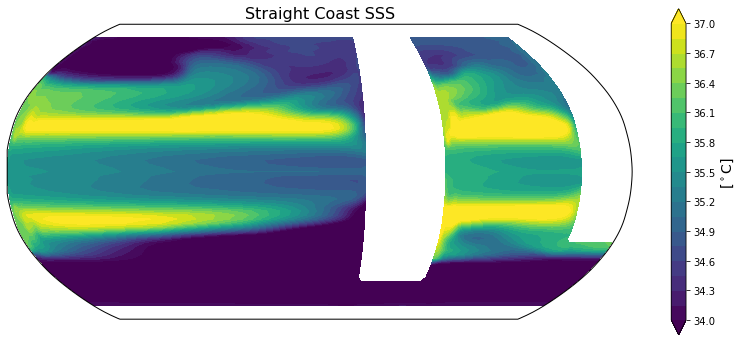

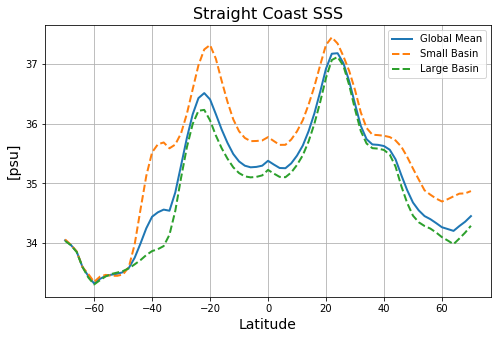

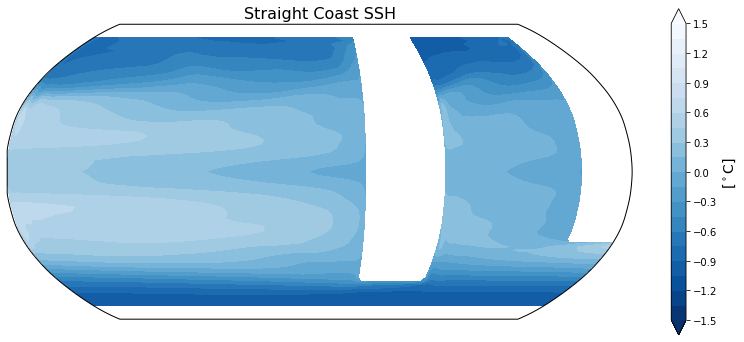

In [11]:
sst_avg = np.nanmean(dy['tos'], axis=0)
sss_avg = np.nanmean(dy['sos'], axis=0)
ssh_avg = np.nanmean(dy['zos'], axis=0)

b = np.linspace(0, 30, 21, endpoint=True)
t = np.linspace(0, 30, 11, endpoint=True)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(dy['xh'], dy['yh'], sst_avg, b, cmap='magma', extend='both',  transform=ccrs.PlateCarree())
cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[$^\circ$C]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('{} SST'.format(case), fontsize=16)
plt.show()

plt.subplots(figsize=(8,5))
plt.plot(dy['yh'], np.nanmean(sst_avg, axis=1), linewidth=2, label='Global Mean')
# Following two lines are for configurations with more than one basin
plt.plot(dy['yh'], np.nanmean(sst_avg[:,x_west:x_east], axis=1), '--',linewidth=2, label='Small Basin')
plt.plot(dy['yh'], np.nanmean(sst_avg[:,:x_west], axis=1), '--', linewidth=2, label='Large Basin')
#
plt.ylabel('[C]', fontsize=14), plt.xlabel('Latitude', fontsize=14)
plt.title('{} SST'.format(case), fontsize=16)
plt.grid()
plt.legend()
plt.show()

b_salt = np.linspace(34, 37, 21, endpoint=True)
t_salt = np.linspace(34, 37, 11, endpoint=True)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(dy['xh'], dy['yh'], sss_avg, b_salt, extend='both',  transform=ccrs.PlateCarree())
cbar = plt.colorbar(ticks=t_salt, boundaries=t_salt, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[$^\circ$C]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('{} SSS'.format(case), fontsize=16)
plt.show()

plt.subplots(figsize=(8,5))
plt.plot(dy['yh'], np.nanmean(sss_avg, axis=1), linewidth=2, label='Global Mean')
# Following two lines are for configurations with more than one basin
plt.plot(dy['yh'], np.nanmean(sss_avg[:,x_west:x_east], axis=1), '--', linewidth=2, label='Small Basin')
plt.plot(dy['yh'], np.nanmean(sss_avg[:,:x_west], axis=1), '--', linewidth=2, label='Large Basin')
#
plt.ylabel('[psu]', fontsize=14), plt.xlabel('Latitude', fontsize=14)
plt.title('{} SSS'.format(case), fontsize=16)
plt.grid()
plt.legend()
plt.show()

b_ssh = np.linspace(-1.5, 1.5, 21, endpoint=True)
t_ssh = np.linspace(-1.5, 1.5, 11, endpoint=True)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(dy['xh'], dy['yh'], ssh_avg, b_ssh, cmap='Blues_r', extend='both',  transform=ccrs.PlateCarree())
cbar = plt.colorbar(ticks=t_ssh, boundaries=t_ssh, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[$^\circ$C]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('{} SSH'.format(case), fontsize=16)
plt.show()

# Calculate and plot overturning streamfunction

In [76]:
# Calculate global mean, residual, and residual mean overturning streamfunction
sfn_mean, sfn_res, sfn_resmean = calculate_global_sfn(vmo, vhGM)

#===========================================
# Comment out the lines below if running AQUA or RIDGE simulations (or simulations with only 1 basin)
# The following lines compute streamfunctions for separate basins.
sfn_small_mean, sfn_small_res, sfn_small_resmean = calculate_basin_sfn(vmo, vhGM, x_west, x_east, y, y_north)
sfn_large_mean, sfn_large_res, sfn_large_resmean = calculate_basin_sfn(vmo, vhGM, 0, x_west, y, y_north)
sfn_so_mean, sfn_so_res, sfn_so_resmean = calculate_basin_sfn(vmo, vhGM, 0, 360, y_south, y)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice


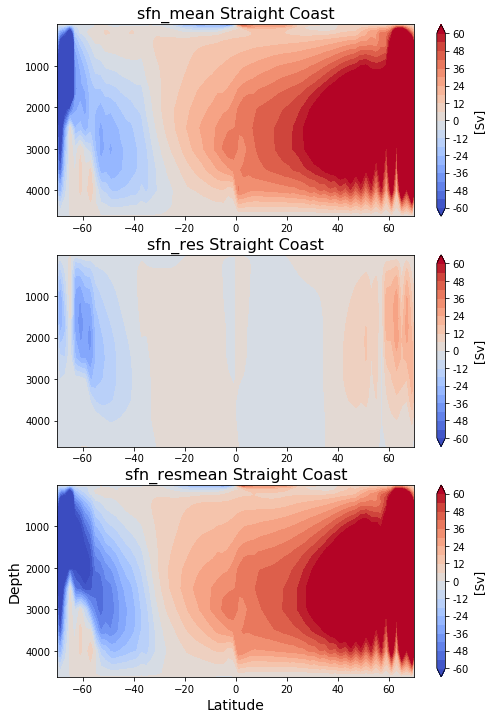

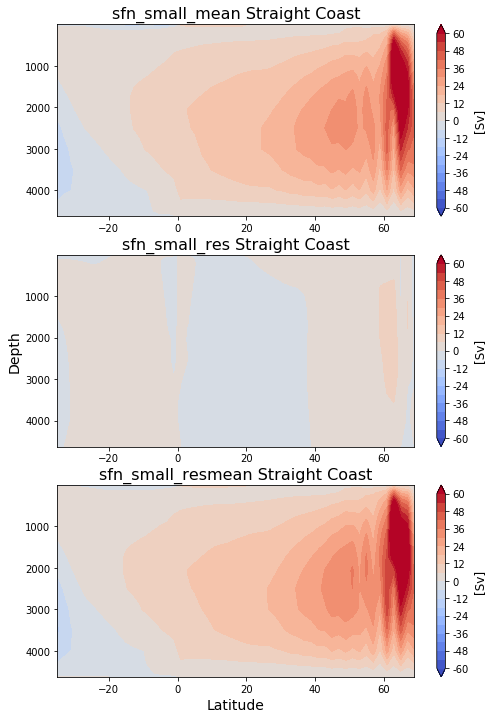

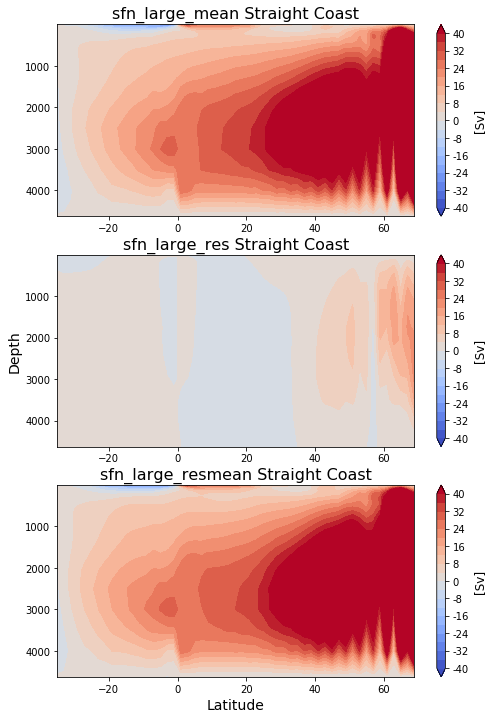

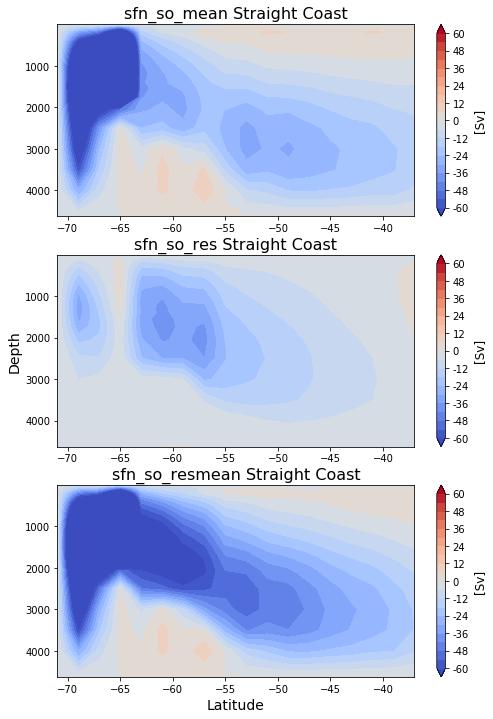

In [84]:
# Plot global mean, residual, and residual mean overturning streamfunction
plot_global_sfn(sfn_mean, sfn_res, sfn_resmean, 60, -70, 70)

#===========================================
# Comment out the lines below if running AQUA or RIDGE simulations (or simulations with only 1 basin)
# The following lines plot streamfunctions for separate basins.
plot_basin_sfn(sfn_small_mean, sfn_small_res, sfn_small_resmean, 60, y, y_north)
plot_basin_sfn(sfn_large_mean, sfn_large_res, sfn_large_resmean, 40, y, y_north)
plot_basin_sfn(sfn_so_mean, sfn_so_res, sfn_so_resmean, 60, y_south, y)


# Calculate and plot meridional ocean heat transport

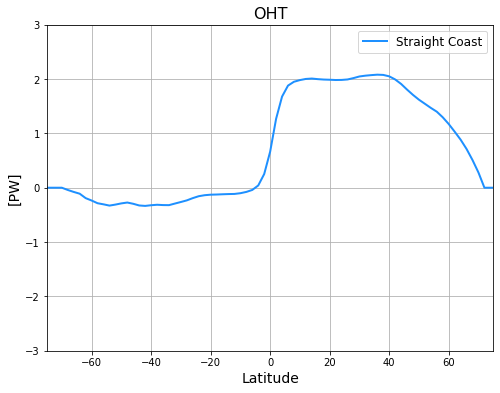

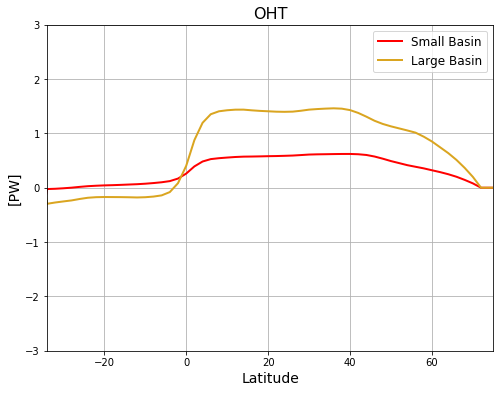

In [60]:
OHT = calculate_OHT(T_ady_2d, T_diffy_2d)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dm['yq']+1, OHT, color='dodgerblue', linewidth=2, label=case)
plt.title('OHT', fontsize=16)
plt.grid()
plt.xlim(-75,75)
plt.ylim(-3, 3)
plt.legend(fontsize=12)
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[PW]', fontsize=14)
#plt.savefig('path/to/figure', bbox_inches='tight')
plt.show()

OHT_small = calculate_OHT(T_ady_2d[:,:,x_west:x_east], T_diffy_2d[:,:,x_west:x_east])
OHT_large = calculate_OHT(T_ady_2d[:,:,:x_west], T_diffy_2d[:,:,:x_west])

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dm['yq']+1, OHT_small, color='red', linewidth=2, label='Small Basin')
ax.plot(dm['yq']+1, OHT_large, color='goldenrod', linewidth=2, label='Large Basin')
plt.title('OHT', fontsize=16)
plt.grid()
plt.xlim(-34,75)
plt.ylim(-3, 3)
plt.legend(fontsize=12)
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[PW]', fontsize=14)
#plt.savefig('path/to/figure', bbox_inches='tight')
plt.show()

# Plot salinity and temperature sections

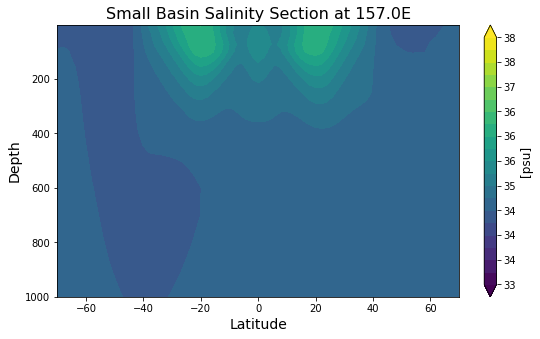

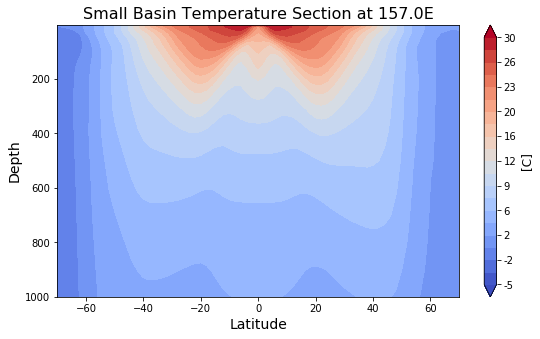

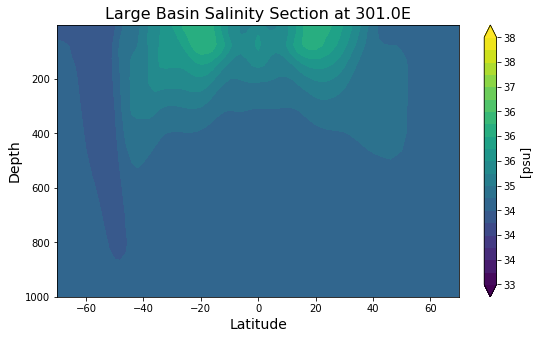

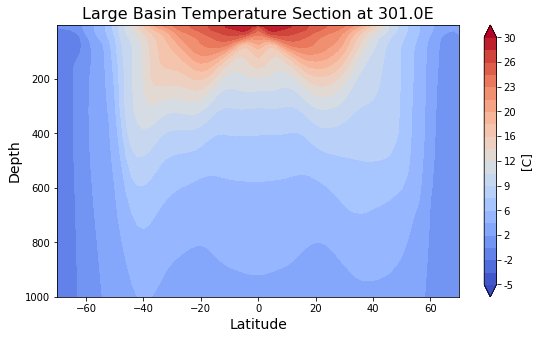

In [51]:
salinity = dy['so'][:]
temperature = dy['thetao'][:]
salt = np.nanmean(salinity[-361:,:,:,:], axis=0)
temp = np.nanmean(temperature[-361:,:,:,:], axis=0)
z = np.where(dy['zl'] == 1000)[0][0] + 1

plot_salt_section('Small Basin', 78, z)
plot_temp_section('Small Basin', 78, z)
plot_salt_section('Large Basin', 150, z)
plot_temp_section('Large Basin', 150, z)